In [1]:
import numpy as np
import matplotlib.pyplot as plt

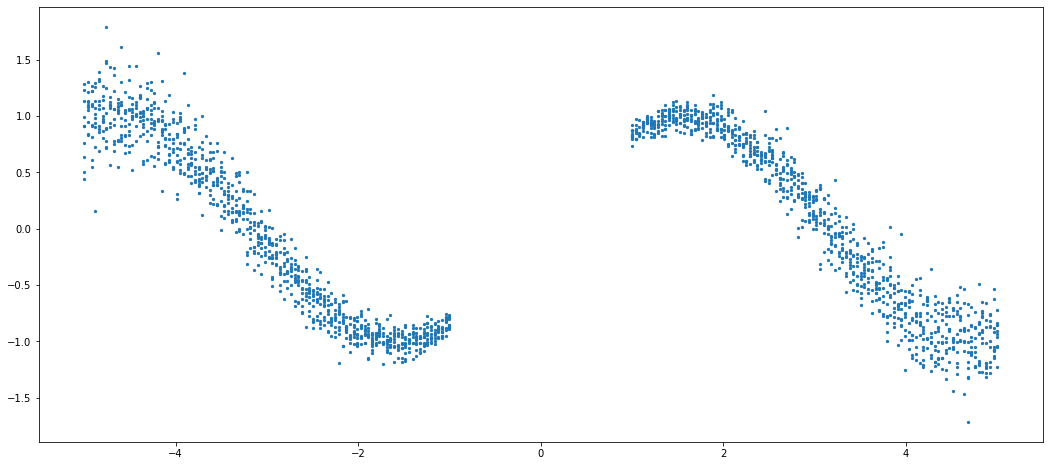

In [2]:
X = []
Y = []
for _ in range(10):
    x = np.concatenate([np.linspace(-5, -1, 100), np.linspace(1, 5, 100)])
    X.append(x)
    Y.append(np.sin(x) + np.random.randn(*x.shape) * x/20)
X = np.concatenate(X)
Y = np.concatenate(Y)

plt.figure(figsize=[18, 8])
plt.scatter(X, Y, s=5)
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.transform = nn.Sequential(nn.Dropout(0.1),
                                       nn.Linear(5, 16),
                                       nn.ReLU(),
                                       
                                       nn.Dropout(0.1),
                                       nn.Linear(16, 32),
                                       nn.ReLU(),
                                       
                                       nn.Dropout(0.1),
                                       nn.Linear(32, 64),
                                       nn.ReLU(),
                                       
                                       nn.Dropout(0.1),
                                       nn.Linear(64, 32),
                                       nn.ReLU(),
            
                                       nn.Dropout(0.1),
                                       nn.Linear(32, 16),
                                       nn.ReLU(),
                                       
                                       nn.Dropout(0.1),
                                       nn.Linear(16, 2))
    
    def get_loss(self, y, mean, logvar, epsilon=1e-7):
        # y : (B, 1)
        # mean : (B, 1)
        # logvar : (B, 1)
        
        negative_log_likelihood = 0.5 * logvar + \
                                  0.5 * np.log(2 * np.pi) + \
                                  0.5 * (y - mean) ** 2 / torch.exp(logvar)
                
        return torch.mean(negative_log_likelihood)
        
    def forward(self, x):
        # x : (B, 1)
        
        # (B, 2)
        output = self.transform(x)
        # (B, 1), (B, 1)
        mean, logvar = output[:, 0:1], output[:, 1:2]
        
        return mean, logvar
        
        

In [5]:
model = Model()
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
print(optimizer)

Model(
  (transform): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=5, out_features=16, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=32, out_features=64, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.1, inplace=False)
    (13): Linear(in_features=32, out_features=16, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=16, out_features=2, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-06
)


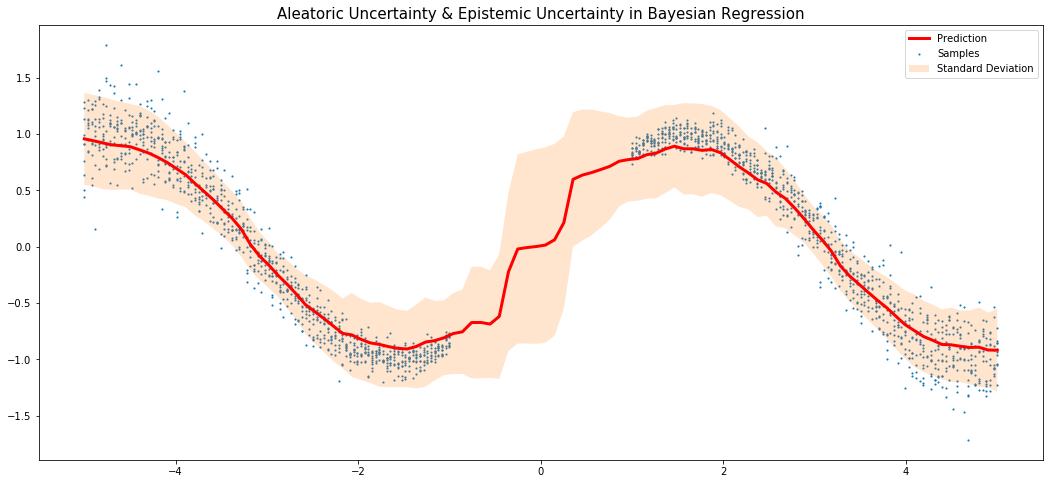

KeyboardInterrupt: 

In [7]:
from IPython import display
import matplotlib.pyplot as plt

def preprocess(X):
    return np.array([X**0, X, X**2, X**3, X**4])

X_tensor = torch.from_numpy(preprocess(X).T).float()
Y_tensor = torch.from_numpy(Y).float()[:, None]

step = 0
model.train()
while(True):
    model.zero_grad()
    mean, logvar = model(X_tensor)

    loss = model.get_loss(Y_tensor, mean, logvar)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        display.clear_output()
        
        X_test = np.linspace(-5, 5, 100)
        X_test_tensor = torch.from_numpy(preprocess(X_test).T).float()

        _means = []
        _vars = []
        for _ in range(1000):
            mean, logvar = model(X_test_tensor)
            _mean = mean.data.numpy()[:, 0]
            _means.append(_mean)
            _var = torch.exp(logvar).data.numpy()[:, 0]
            _vars.append(_var)

        _means = np.stack(_means)
        _mean = np.mean(_means, axis=0)
        _vars = np.stack(_vars)
        _var = np.mean(_vars, axis=0) + np.var(_means, axis=0)

        plt.figure(figsize=[18, 8])
        plt.title('Aleatoric Uncertainty & Epistemic Uncertainty in Bayesian Regression', size=15)
        plt.scatter(X, Y, s=5, label='Samples', marker='.')
        plt.plot(X_test, _mean, color='red', label='Prediction', linewidth=3)
        plt.fill_between(X_test, _mean - _var**0.5, _mean + _var**0.5, alpha=0.2, label='Standard Deviation')
        plt.legend()
        plt.show()
        
    step += 1